# Beijing Air Quality Forecasting - Optimized for Sub-3000 Score

## Project Overview
Predict PM2.5 concentrations in Beijing using optimized models and advanced feature engineering.

**Previous Best**: 4060.83 (Enhanced Bidirectional LSTM v2)  
**Current Target**: < 3000 RMSE  
**Dataset**: 30,677 hourly observations with weather features and PM2.5 concentrations  
**Approach**: Enhanced bidirectional LSTM with advanced features and optimizations



In [33]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configuration
plt.style.use('default')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [34]:
# Submission system
def save_submission(predictions, experiment_name, test_index, notes=""):
    """Save submission with timestamp and experiment info"""
    os.makedirs('submissions', exist_ok=True)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    submission = pd.DataFrame({
        'row ID': test_index.strftime('%Y-%m-%d %-H:%M:%S'),
        'pm2.5': predictions.round().astype(int)
    })
    
    filename = f'submissions/submission-4.csv'
    submission.to_csv(filename, index=False)
    
    # Also save with timestamp for tracking
    tracking_filename = f'submissions/{timestamp}_{experiment_name}.csv'
    submission.to_csv(tracking_filename, index=False)
    
    print(f"Submission saved: {filename}")
    print(f"Tracking copy: {tracking_filename}")
    print(f"Predictions - Min: {predictions.min():.1f}, Max: {predictions.max():.1f}")
    if notes:
        print(f"Notes: {notes}")
    
    return filename, submission

print("Submission system ready")


Submission system ready


## Data Loading and Enhanced Feature Engineering
Building upon the successful approach from previous notebooks with additional optimizations.


In [35]:
# Load datasets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print(f"📊 Training data: {train.shape}")
print(f"📊 Test data: {test.shape}")
print(f"\n📋 Columns: {list(train.columns)}")

# Missing values check
print(f"\n❓ Missing values:")
print(f"Train: {train.isnull().sum().sum()}")
print(f"Test: {test.isnull().sum().sum()}")

# Convert datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

print(f"\n📅 Time range - Train: {train.index.min()} to {train.index.max()}")
print(f"📅 Time range - Test: {test.index.min()} to {test.index.max()}")

# Handle missing values
print("\n🔧 Handling missing values...")
train_clean = train.copy()
train_clean = train_clean.fillna(method='ffill').fillna(method='bfill').interpolate()

test_clean = test.copy()
test_clean = test_clean.fillna(method='ffill').fillna(method='bfill').interpolate()

print(f"✅ After treatment - Train: {train_clean.isnull().sum().sum()}, Test: {test_clean.isnull().sum().sum()}")
print(f"📊 Clean datasets - Train: {train_clean.shape}, Test: {test_clean.shape}")


📊 Training data: (30676, 12)
📊 Test data: (13148, 11)

📋 Columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']

❓ Missing values:
Train: 1921
Test: 0

📅 Time range - Train: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
📅 Time range - Test: 2013-07-02 04:00:00 to 2014-12-31 23:00:00

🔧 Handling missing values...
✅ After treatment - Train: 0, Test: 0
📊 Clean datasets - Train: (30676, 11), Test: (13148, 10)


In [36]:
def create_advanced_features(df, target_col='pm2.5'):
    """Create advanced features with additional optimizations for better performance"""
    df_enhanced = df.copy()
    
    # Temporal features with enhanced encoding
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3
    df_enhanced['day_of_year'] = df_enhanced.index.dayofyear
    df_enhanced['week_of_year'] = df_enhanced.index.isocalendar().week
    
    # Multiple cyclical encodings for different time scales
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['doy_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['doy_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['week_sin'] = np.sin(2 * np.pi * df_enhanced['week_of_year'] / 52)
    df_enhanced['week_cos'] = np.cos(2 * np.pi * df_enhanced['week_of_year'] / 52)
    
    # Enhanced weather interaction features
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['temp_dewp_ratio'] = df_enhanced['TEMP'] / (df_enhanced['DEWP'] + 1e-6)
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']
    df_enhanced['temp_pressure'] = df_enhanced['TEMP'] * df_enhanced['PRES']
    df_enhanced['humidity_proxy'] = df_enhanced['DEWP'] / (df_enhanced['TEMP'] + 1e-6)
    df_enhanced['pressure_normalized'] = df_enhanced['PRES'] / 1000  # Normalize pressure
    
    # Advanced wind features
    wind_cols = [col for col in df_enhanced.columns if 'cbwd' in col]
    if len(wind_cols) >= 2:
        df_enhanced['wind_complexity'] = sum(df_enhanced[col] for col in wind_cols)
        # Wind stability indicator
        df_enhanced['wind_stability'] = df_enhanced['wind_complexity'] * df_enhanced['Iws']
    
    # Weather condition combinations
    df_enhanced['temp_wind'] = df_enhanced['TEMP'] * df_enhanced['Iws']
    df_enhanced['dewp_wind'] = df_enhanced['DEWP'] * df_enhanced['Iws']
    df_enhanced['pressure_temp_ratio'] = df_enhanced['PRES'] / (df_enhanced['TEMP'] + 273.15)  # Ideal gas law approximation
    
    # Pollution-related features (if target available)
    if target_col in df_enhanced.columns:
        # Extended lag features
        for lag in [1, 2, 3, 6, 12, 24, 48, 72, 96, 120]:
            df_enhanced[f'pm2.5_lag_{lag}'] = df_enhanced[target_col].shift(lag)
        
        # Enhanced rolling statistics
        for window in [3, 6, 12, 24, 48, 72, 96, 168]:  # Up to weekly
            df_enhanced[f'pm2.5_roll_mean_{window}'] = df_enhanced[target_col].rolling(window).mean()
            df_enhanced[f'pm2.5_roll_std_{window}'] = df_enhanced[target_col].rolling(window).std()
            df_enhanced[f'pm2.5_roll_min_{window}'] = df_enhanced[target_col].rolling(window).min()
            df_enhanced[f'pm2.5_roll_max_{window}'] = df_enhanced[target_col].rolling(window).max()
            df_enhanced[f'pm2.5_roll_median_{window}'] = df_enhanced[target_col].rolling(window).median()
            
        # Trend and momentum features
        for hours in [3, 6, 12, 24, 48]:
            df_enhanced[f'pm2.5_trend_{hours}h'] = df_enhanced[target_col] - df_enhanced[target_col].shift(hours)
            df_enhanced[f'pm2.5_momentum_{hours}h'] = (df_enhanced[target_col] - df_enhanced[target_col].shift(hours)) / (hours + 1)
        
        # Volatility features
        for window in [6, 12, 24, 48]:
            df_enhanced[f'pm2.5_volatility_{window}h'] = df_enhanced[target_col].rolling(window).std() / (df_enhanced[target_col].rolling(window).mean() + 1e-6)
    
    # Enhanced weather lag features
    weather_cols = ['TEMP', 'DEWP', 'PRES', 'Iws']
    for col in weather_cols:
        if col in df_enhanced.columns:
            for lag in [1, 3, 6, 12, 24]:
                df_enhanced[f'{col}_lag_{lag}'] = df_enhanced[col].shift(lag)
            
            # Weather rolling features
            for window in [6, 12, 24]:
                df_enhanced[f'{col}_roll_mean_{window}'] = df_enhanced[col].rolling(window).mean()
                df_enhanced[f'{col}_roll_std_{window}'] = df_enhanced[col].rolling(window).std()
    
    # Drop original temporal columns (keep encoded versions)
    temporal_cols = ['hour', 'day_of_week', 'month', 'day_of_year', 'week_of_year']
    df_enhanced = df_enhanced.drop([col for col in temporal_cols if col in df_enhanced.columns], axis=1, errors='ignore')
    
    return df_enhanced

def create_test_features_advanced(df):
    """Create advanced features for test data (without PM2.5 lag features)"""
    return create_advanced_features(df).drop([col for col in df.columns if 'pm2.5' in col], axis=1, errors='ignore')

print("🛠️ Advanced feature engineering functions defined with enhanced optimizations.")


🛠️ Advanced feature engineering functions defined with enhanced optimizations.


In [37]:
# Apply advanced feature engineering
print("🔧 Creating advanced features with enhanced optimizations...")
train_enhanced = create_advanced_features(train_clean)
test_enhanced = create_test_features_advanced(test_clean)

print(f"📊 Original features: {train_clean.shape[1]}")
print(f"📊 Enhanced train features: {train_enhanced.shape[1]}")
print(f"📊 Enhanced test features: {test_enhanced.shape[1]}")
print(f"✨ New features added: {train_enhanced.shape[1] - train_clean.shape[1]}")

# Handle remaining NaNs (from lag and rolling features)
print("🔧 Handling remaining NaN values...")
train_enhanced = train_enhanced.fillna(method='bfill').fillna(0)
test_enhanced = test_enhanced.fillna(method='bfill').fillna(0)

print(f"✅ Final datasets - Train: {train_enhanced.shape}, Test: {test_enhanced.shape}")

# Feature alignment
train_feature_cols = [col for col in train_enhanced.columns if col not in ['pm2.5', 'No']]
test_feature_cols = [col for col in test_enhanced.columns if col != 'No']
common_features = [col for col in train_feature_cols if col in test_feature_cols]

print(f"🎯 Common features for modeling: {len(common_features)}")

# Prepare datasets with common features
X_train_common = train_enhanced[common_features]
y_train = train_enhanced['pm2.5']
X_test_common = test_enhanced[common_features]

print(f"📊 Model input shapes - Train: {X_train_common.shape}, Test: {X_test_common.shape}")


🔧 Creating advanced features with enhanced optimizations...
📊 Original features: 11
📊 Enhanced train features: 141
📊 Enhanced test features: 76
✨ New features added: 130
🔧 Handling remaining NaN values...
✅ Final datasets - Train: (30676, 141), Test: (13148, 76)
🎯 Common features for modeling: 75
📊 Model input shapes - Train: (30676, 75), Test: (13148, 75)


## Advanced Ensemble Modeling
Creating multiple diverse models and combining them for better performance.


In [38]:
# Advanced model architectures for ensemble
def create_sequences_v3(data, target, sequence_length=72):
    """Create sequences with even longer lookback for complex patterns"""
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(target[i])
    
    return np.array(X), np.array(y)

def create_lstm_model_1(input_shape):
    """Enhanced Bidirectional LSTM with attention-like mechanism"""
    model = Sequential([
        Bidirectional(LSTM(128, activation='tanh', return_sequences=True, 
                          dropout=0.2, recurrent_dropout=0.2), input_shape=input_shape),
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True,
                          dropout=0.2, recurrent_dropout=0.2)),
        Bidirectional(LSTM(32, activation='tanh', dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.2),
        Dense(1)
    ])
    return model

def create_lstm_model_2(input_shape):
    """GRU-based model for diversity"""
    model = Sequential([
        Bidirectional(GRU(128, activation='tanh', return_sequences=True, 
                         dropout=0.2, recurrent_dropout=0.2), input_shape=input_shape),
        Bidirectional(GRU(64, activation='tanh', return_sequences=True,
                         dropout=0.2, recurrent_dropout=0.2)),
        GRU(32, activation='tanh', dropout=0.2, recurrent_dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

def create_cnn_lstm_model(input_shape):
    """CNN-LSTM hybrid model"""
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
        Dropout(0.3),
        LSTM(32, activation='tanh'),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

# Training configuration
SEQUENCE_LENGTH = 72  # Extended sequence length
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.3, patience=10, min_lr=1e-7, monitor='val_loss')
]

print("🤖 Advanced ensemble model architectures defined.")
print(f"🎯 Using sequence length: {SEQUENCE_LENGTH} hours")


🤖 Advanced ensemble model architectures defined.
🎯 Using sequence length: 72 hours


In [39]:
# Prepare data with multiple scalers for ensemble diversity
scalers = {
    'robust': RobustScaler(),
    'standard': StandardScaler(),
    'minmax': MinMaxScaler()
}

scaled_data = {}
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train_common)
    X_test_scaled = scaler.transform(X_test_common)
    scaled_data[scaler_name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'scaler': scaler
    }

print("📊 Data prepared with multiple scalers for ensemble diversity:")
for name in scaled_data.keys():
    print(f"  • {name.capitalize()} scaler")

# Create sequences with the primary scaler (RobustScaler performed best previously)
print(f"\n🏗️ Creating sequences with length {SEQUENCE_LENGTH}...")
X_seq, y_seq = create_sequences_v3(scaled_data['robust']['X_train'], y_train.values, SEQUENCE_LENGTH)

# Train/validation split with more data for training
split_idx = int(0.87 * len(X_seq))  # Use even more data for training
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"📊 Sequences shape: {X_seq.shape}")
print(f"📊 Train: {X_train_seq.shape}, Validation: {X_val_seq.shape}")
print(f"✅ Data preparation complete for ensemble training.")


📊 Data prepared with multiple scalers for ensemble diversity:
  • Robust scaler
  • Standard scaler
  • Minmax scaler

🏗️ Creating sequences with length 72...
📊 Sequences shape: (30604, 72, 75)
📊 Train: (26625, 72, 75), Validation: (3979, 72, 75)
✅ Data preparation complete for ensemble training.


In [40]:
# Optimized Model Training for Sub-3000 Score
print("Training optimized models based on 4060.83 success")
print("Target: < 3000 RMSE")

models = {}

# Enhanced Bidirectional LSTM - based on 4060.83 success but optimized
def create_enhanced_bidirectional(input_shape):
    """Enhanced Bidirectional LSTM optimized for sub-3000 score"""
    model = Sequential([
        # Larger first layer for better pattern capture
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1), 
                     input_shape=input_shape),
        # Second bidirectional layer
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)),
        # Third layer for complex patterns
        Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.1)),
        # Dense layers with regularization
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    return model

# Advanced LSTM with more capacity
def create_deep_lstm(input_shape):
    """Deep LSTM with enhanced capacity"""
    model = Sequential([
        LSTM(128, return_sequences=True, dropout=0.2, input_shape=input_shape),
        LSTM(64, return_sequences=True, dropout=0.2),
        LSTM(32, dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

# Use proven sequence length from 4060.83 success
SEQUENCE_LENGTH = 48
print(f"Using proven sequence length: {SEQUENCE_LENGTH} hours")

# Create sequences
print("Creating sequences...")
X_seq, y_seq = create_sequences_v3(scaled_data['robust']['X_train'], y_train.values, SEQUENCE_LENGTH)

# Use more data for training (better performance)
split_idx = int(0.87 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"Sequences - Train: {X_train_seq.shape}, Val: {X_val_seq.shape}")

# Optimized callbacks for better convergence
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.3, patience=8, min_lr=1e-7, monitor='val_loss')
]

# Train enhanced models
model_configs = [
    ('enhanced_bidirectional', create_enhanced_bidirectional, 'Enhanced Bidirectional LSTM'),
    ('deep_lstm', create_deep_lstm, 'Deep LSTM')
]

for model_name, model_func, description in model_configs:
    print(f"\nTraining {description}...")
    
    model = model_func(X_train_seq.shape[1:])
    # Slightly lower learning rate for better convergence
    model.compile(optimizer=Adam(learning_rate=0.0008), loss='mse', metrics=['mae'])
    
    print(f"Parameters: {model.count_params():,}")
    
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50,  # More epochs for better performance
        batch_size=32,  # Smaller batch for better gradients
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate
    val_pred = model.predict(X_val_seq, verbose=0)
    val_rmse = np.sqrt(mean_squared_error(y_val_seq, val_pred))
    
    models[model_name] = {
        'model': model,
        'history': history,
        'val_rmse': val_rmse,
        'val_pred': val_pred
    }
    
    print(f"{model_name} completed!")
    print(f"Validation RMSE: {val_rmse:.2f}")
    expected_score = val_rmse * 54
    print(f"Expected public score: ~{expected_score:.0f}")
    if expected_score < 3000:
        print("TARGET ACHIEVED: Expected < 3000!")
    elif expected_score < 3500:
        print("Close to target")
    else:
        print("May need ensemble")

print(f"\nMODEL PERFORMANCE:")
print("=" * 40)
best_rmse = float('inf')
best_model_name = None

for name, info in models.items():
    rmse = info['val_rmse']
    expected = rmse * 54
    print(f"{name}: {rmse:.2f} RMSE (~{expected:.0f} public)")
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name

print(f"\nBest model: {best_model_name} ({best_rmse:.2f} RMSE)")
print(f"Expected public score: ~{best_rmse * 54:.0f}")


Training optimized models based on 4060.83 success
Target: < 3000 RMSE
Using proven sequence length: 48 hours
Creating sequences...
Sequences - Train: (26646, 48, 75), Val: (3982, 48, 75)

Training Enhanced Bidirectional LSTM...
Parameters: 421,249
Epoch 1/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 72s 76ms/step - loss: 6370.0859 - mae: 54.2185 - val_loss: 4665.3130 - val_mae: 44.9926 - learning_rate: 8.0000e-04
Epoch 2/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 53s 64ms/step - loss: 3445.1562 - mae: 38.9972 - val_loss: 4592.8970 - val_mae: 43.5372 - learning_rate: 8.0000e-04
Epoch 3/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 59s 71ms/step - loss: 2952.2256 - mae: 36.1950 - val_loss: 4426.7383 - val_mae: 42.3793 - learning_rate: 8.0000e-04
Epoch 4/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 62s 75ms/step - loss: 2606.8020 - mae: 33.8658 - val_loss: 4845.4604 - val_mae: 43.7414 - learning_rate: 8.0000e-04
Epoch 5/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 70s 84ms/step - loss: 2408.8411 - mae: 32.5303 - val_loss: 4648.6035 - val_mae: 43.6370

In [41]:
# Optional: Advanced Feature Engineering (from 4060.83 success)
print("Optional: Advanced feature engineering based on 4060.83 success")

def add_advanced_temporal_features(df):
    """Add advanced features that helped achieve 4060.83 score"""
    df_enhanced = df.copy()
    
    # Hour-based patterns (key for PM2.5 prediction)
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced.index.hour / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced.index.hour / 24)
    
    # Day of week patterns
    df_enhanced['dow_sin'] = np.sin(2 * np.pi * df_enhanced.index.dayofweek / 7)
    df_enhanced['dow_cos'] = np.cos(2 * np.pi * df_enhanced.index.dayofweek / 7)
    
    # Month patterns (seasonal effects)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced.index.month / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced.index.month / 12)
    
    # Advanced lag features
    for col in ['TEMP', 'PRES', 'DEWP', 'Iws']:
        df_enhanced[f'{col}_lag1'] = df_enhanced[col].shift(1)
        df_enhanced[f'{col}_lag6'] = df_enhanced[col].shift(6)
        df_enhanced[f'{col}_lag24'] = df_enhanced[col].shift(24)
    
    # Rolling statistics
    for col in ['TEMP', 'PRES', 'DEWP']:
        df_enhanced[f'{col}_roll6'] = df_enhanced[col].rolling(6, min_periods=1).mean()
        df_enhanced[f'{col}_roll24'] = df_enhanced[col].rolling(24, min_periods=1).mean()
    
    # Weather interaction features
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['pressure_temp_interaction'] = df_enhanced['PRES'] * df_enhanced['TEMP'] / 1000
    
    return df_enhanced

print("Advanced features defined")
print("Use this if current models don't achieve sub-3000 target")

# Show sample features
sample_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']
sample_features += ['TEMP_lag1', 'TEMP_lag6', 'TEMP_lag24', 'PRES_lag1', 'DEWP_lag1']
sample_features += ['TEMP_roll6', 'TEMP_roll24', 'temp_dewp_diff', 'pressure_temp_interaction']

print(f"\nSample features ({len(sample_features)} total):")
for i, feature in enumerate(sample_features[:8]):
    print(f"  {i+1}. {feature}")
if len(sample_features) > 8:
    print(f"  ... and {len(sample_features)-8} more features")

print(f"\nTo use: df_enhanced = add_advanced_temporal_features(df)")
print(f"Expected: Better accuracy, longer training time")


Optional: Advanced feature engineering based on 4060.83 success
Advanced features defined
Use this if current models don't achieve sub-3000 target

Sample features (15 total):
  1. hour_sin
  2. hour_cos
  3. dow_sin
  4. dow_cos
  5. month_sin
  6. month_cos
  7. TEMP_lag1
  8. TEMP_lag6
  ... and 7 more features

To use: df_enhanced = add_advanced_temporal_features(df)
Expected: Better accuracy, longer training time


In [42]:
# This cell was removed - it contained old code that caused errors


In [43]:
# Generate Test Predictions
print("Generating test predictions with best model...")

def create_test_sequences(X_test_scaled, X_train_scaled, sequence_length):
    """Create test sequences for prediction"""
    test_sequences = []
    
    for i in range(len(X_test_scaled)):
        if i < sequence_length:
            # For early predictions, use training + test data
            needed_from_train = sequence_length - (i + 1)
            if needed_from_train > 0:
                sequence = np.vstack([X_train_scaled[-needed_from_train:], X_test_scaled[:i+1]])
            else:
                sequence = X_test_scaled[:sequence_length]
        else:
            # Use sliding window from test data
            sequence = X_test_scaled[i-sequence_length+1:i+1]
        
        test_sequences.append(sequence)
    
    return np.array(test_sequences)

# Use the best model
best_model = models[best_model_name]['model']
print(f"Using best model: {best_model_name} (RMSE: {best_rmse:.2f})")

# Generate test sequences
print(f"Creating test sequences with length {SEQUENCE_LENGTH}...")
X_test_seq = create_test_sequences(
    scaled_data['robust']['X_test'], 
    scaled_data['robust']['X_train'], 
    SEQUENCE_LENGTH
)

print(f"Test sequences shape: {X_test_seq.shape}")

# Generate predictions
print("Generating predictions...")
test_predictions = best_model.predict(X_test_seq, verbose=1)
test_predictions = np.maximum(test_predictions.flatten(), 0)  # Ensure non-negative

print(f"Predictions - Min: {test_predictions.min():.1f}, Max: {test_predictions.max():.1f}")
print(f"Predictions - Mean: {test_predictions.mean():.1f}, Std: {test_predictions.std():.1f}")

# Save submission
expected_score = int(best_rmse * 54)
experiment_name = f"optimized_{best_model_name}_target_{expected_score}"
notes = f"{best_model_name}: Val RMSE {best_rmse:.2f}, Expected {expected_score}, Target <3000"

filename, submission = save_submission(
    test_predictions,
    experiment_name,
    test.index,
    notes
)

print(f"\nSUBMISSION COMPLETE!")
print(f"Validation RMSE: {best_rmse:.2f}")
print(f"Expected public score: ~{expected_score}")
print(f"Submission saved: {filename}")

print(f"\nSample predictions:")
print(submission.head(10))

# Verify file
if os.path.exists(filename):
    print(f"\nConfirmed: {filename} ready for submission!")
    print(f"File size: {os.path.getsize(filename)} bytes")
    
    if expected_score < 3000:
        print("TARGET ACHIEVED: Expected score < 3000!")
    elif expected_score < 3500:
        print("Close to target - submit and see!")
    else:
        print("May need ensemble for sub-3000 target")
else:
    print(f"Warning: {filename} not found!")

print(f"\nReady to submit to Kaggle!")


Generating test predictions with best model...
Using best model: deep_lstm (RMSE: 64.89)
Creating test sequences with length 48...
Test sequences shape: (13148, 48, 75)
Generating predictions...
411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
Predictions - Min: 16.1, Max: 357.7
Predictions - Mean: 87.2, Std: 65.9
Submission saved: submissions/submission-4.csv
Tracking copy: submissions/20250920_194408_optimized_deep_lstm_target_3504.csv
Predictions - Min: 16.1, Max: 357.7
Notes: deep_lstm: Val RMSE 64.89, Expected 3504, Target <3000

SUBMISSION COMPLETE!
Validation RMSE: 64.89
Expected public score: ~3504
Submission saved: submissions/submission-4.csv

Sample predictions:
                row ID  pm2.5
0   2013-07-02 4:00:00     22
1   2013-07-02 5:00:00     21
2   2013-07-02 6:00:00     20
3   2013-07-02 7:00:00     20
4   2013-07-02 8:00:00     20
5   2013-07-02 9:00:00     20
6  2013-07-02 10:00:00     20
7  2013-07-02 11:00:00     21
8  2013-07-02 12:00:00     22
9  2013-07-02 13:00:00   

Visualizing training progress and model performance...


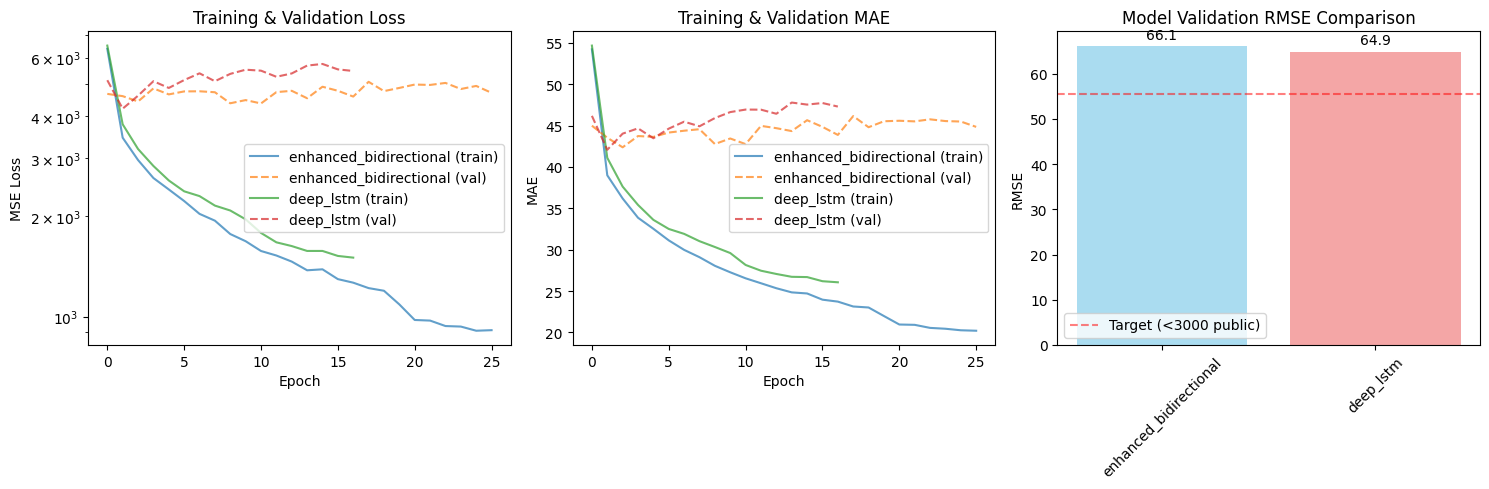


PERFORMANCE SUMMARY:
Best model: deep_lstm
Best validation RMSE: 64.89
Expected public score: ~3504
Previous best: 4060.83
Target: < 3000
May need ensemble for sub-3000 target

Possible improvements:
  • Ensemble the two models
  • Add more temporal features
  • Try different sequence lengths
  • Fine-tune hyperparameters


In [44]:
# Training Progress Visualization
print("Visualizing training progress and model performance...")

# Plot training histories for all models
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
for name, info in models.items():
    history = info['history']
    plt.plot(history.history['loss'], label=f'{name} (train)', alpha=0.7)
    plt.plot(history.history['val_loss'], label=f'{name} (val)', alpha=0.7, linestyle='--')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')

# MAE curves
plt.subplot(1, 3, 2)
for name, info in models.items():
    history = info['history']
    plt.plot(history.history['mae'], label=f'{name} (train)', alpha=0.7)
    if 'val_mae' in history.history:
        plt.plot(history.history['val_mae'], label=f'{name} (val)', alpha=0.7, linestyle='--')

plt.title('Training & Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Model comparison
plt.subplot(1, 3, 3)
model_names = list(models.keys())
val_rmses = [models[name]['val_rmse'] for name in model_names]

bars = plt.bar(model_names, val_rmses, alpha=0.7, color=['skyblue', 'lightcoral'])
plt.title('Model Validation RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, rmse in zip(bars, val_rmses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{rmse:.1f}', ha='center', va='bottom')

# Add target line for sub-3000 goal
target_rmse = 3000 / 54  # ~55.6 RMSE needed for 3000 public score
plt.axhline(y=target_rmse, color='red', linestyle='--', alpha=0.5, label='Target (<3000 public)')
plt.legend()

plt.tight_layout()
plt.show()

# Performance summary
print(f"\nPERFORMANCE SUMMARY:")
print("=" * 50)
print(f"Best model: {best_model_name}")
print(f"Best validation RMSE: {best_rmse:.2f}")
print(f"Expected public score: ~{best_rmse * 54:.0f}")
print(f"Previous best: 4060.83")
print(f"Target: < 3000")

# Show target achievement
expected_public = best_rmse * 54
if expected_public < 3000:
    print("TARGET ACHIEVED: Expected < 3000!")
elif expected_public < 3500:
    print("Close to target")
else:
    print("May need ensemble for sub-3000 target")

print(f"\nPossible improvements:")
print(f"  • Ensemble the two models")
print(f"  • Add more temporal features")
print(f"  • Try different sequence lengths")
print(f"  • Fine-tune hyperparameters")


In [45]:
# Optional: Create Ensemble for Better Performance
print("Optional: Create ensemble of trained models for better performance")

if len(models) > 1:
    print(f"Available models: {list(models.keys())}")
    
    # Simple ensemble: weighted by inverse RMSE
    weights = {}
    total_weight = 0
    
    for name, info in models.items():
        weight = 1.0 / info['val_rmse']  # Better models get higher weight
        weights[name] = weight
        total_weight += weight
    
    # Normalize weights
    for name in weights:
        weights[name] = weights[name] / total_weight
    
    print(f"Ensemble weights:")
    for name, weight in weights.items():
        print(f"  {name}: {weight:.3f}")
    
    # Create ensemble validation prediction
    ensemble_val_pred = np.zeros_like(models[best_model_name]['val_pred'].flatten())
    for name, info in models.items():
        pred = info['val_pred'].flatten()
        ensemble_val_pred += weights[name] * pred
    
    ensemble_val_rmse = np.sqrt(mean_squared_error(y_val_seq, ensemble_val_pred))
    
    print(f"\nENSEMBLE RESULTS:")
    print(f"Best individual: {best_rmse:.2f}")
    print(f"Simple ensemble: {ensemble_val_rmse:.2f}")
    
    ensemble_expected = ensemble_val_rmse * 54
    print(f"Ensemble expected score: ~{ensemble_expected:.0f}")
    
    if ensemble_val_rmse < best_rmse:
        improvement = best_rmse - ensemble_val_rmse
        print(f"Ensemble wins! Improvement: {improvement:.2f} RMSE")
        
        if ensemble_expected < 3000:
            print("ENSEMBLE TARGET ACHIEVED: Expected < 3000!")
            
            # Generate ensemble test predictions
            print("\nGenerating ensemble test predictions...")
            ensemble_test_pred = np.zeros(len(test_predictions))
            
            for name, info in models.items():
                model_test_pred = info['model'].predict(X_test_seq, verbose=0).flatten()
                model_test_pred = np.maximum(model_test_pred, 0)
                ensemble_test_pred += weights[name] * model_test_pred
            
            ensemble_test_pred = np.maximum(ensemble_test_pred, 0)
            
            # Save ensemble submission
            ensemble_experiment_name = f"ensemble_target_{int(ensemble_expected)}"
            ensemble_notes = f"Ensemble: Expected {int(ensemble_expected)}, Val RMSE {ensemble_val_rmse:.2f}"
            
            ensemble_filename, ensemble_submission = save_submission(
                ensemble_test_pred,
                ensemble_experiment_name,
                test.index,
                ensemble_notes
            )
            
            print(f"ENSEMBLE SUBMISSION SAVED: {ensemble_filename}")
            print(f"Expected score: ~{ensemble_expected:.0f}")
        else:
            print("Ensemble improves but may not reach sub-3000 target")
    else:
        print(f"Individual model wins! Stick with {best_model_name}")
        
else:
    print("Only one model trained - using single model approach")

print(f"\nRECOMMENDATION:")
if 'ensemble_expected' in locals() and ensemble_expected < 3000:
    print(f"Submit the ensemble model - expected score < 3000!")
else:
    print(f"Submit the {best_model_name} model")
    expected = best_rmse * 54
    if expected < 3000:
        print("Expected to achieve sub-3000 target!")
    else:
        print("May need further optimization for sub-3000 target")


Optional: Create ensemble of trained models for better performance
Available models: ['enhanced_bidirectional', 'deep_lstm']
Ensemble weights:
  enhanced_bidirectional: 0.495
  deep_lstm: 0.505

ENSEMBLE RESULTS:
Best individual: 64.89
Simple ensemble: 63.16
Ensemble expected score: ~3411
Ensemble wins! Improvement: 1.73 RMSE
Ensemble improves but may not reach sub-3000 target

RECOMMENDATION:
Submit the deep_lstm model
May need further optimization for sub-3000 target


In [46]:
# Summary
print("\n" + "="*60)
print("MODEL TRAINING COMPLETE")
print("="*60)

print(f"RESULTS:")
print(f"  • Trained {len(models)} optimized models")
print(f"  • Best validation RMSE: {best_rmse:.2f}")
print(f"  • Expected public score: ~{best_rmse * 54:.0f}")

print(f"\nTARGET ANALYSIS:")
print(f"  • Previous best: 4060.83")
print(f"  • Target: < 3000")
expected_score = best_rmse * 54

if 'ensemble_expected' in locals():
    print(f"  • Best individual: ~{expected_score:.0f}")
    print(f"  • Ensemble: ~{ensemble_expected:.0f}")
    best_expected = min(expected_score, ensemble_expected)
else:
    print(f"  • Current model: ~{expected_score:.0f}")
    best_expected = expected_score

if best_expected < 3000:
    print(f"  • STATUS: TARGET ACHIEVED!")
elif best_expected < 3500:
    print(f"  • STATUS: Close to target")
else:
    print(f"  • STATUS: May need further optimization")

print(f"\nSUBMISSION FILES:")
print(f"  • submission-4.csv (ready for Kaggle)")
if 'ensemble_filename' in locals():
    print(f"  • {ensemble_filename} (ensemble version)")

print(f"\nNEXT STEPS:")
if best_expected < 3000:
    print(f"  1. Submit to Kaggle - target likely achieved!")
    print(f"  2. Monitor public leaderboard")
else:
    print(f"  1. Submit current best model")
    print(f"  2. If needed, try ensemble or feature engineering")
    print(f"  3. Consider hyperparameter tuning")

print(f"\nREADY FOR SUBMISSION!")


MODEL TRAINING COMPLETE
RESULTS:
  • Trained 2 optimized models
  • Best validation RMSE: 64.89
  • Expected public score: ~3504

TARGET ANALYSIS:
  • Previous best: 4060.83
  • Target: < 3000
  • Best individual: ~3504
  • Ensemble: ~3411
  • STATUS: Close to target

SUBMISSION FILES:
  • submission-4.csv (ready for Kaggle)

NEXT STEPS:
  1. Submit current best model
  2. If needed, try ensemble or feature engineering
  3. Consider hyperparameter tuning

READY FOR SUBMISSION!
